# Spatial Interpolation at Estero Bay

This document includes Python codes that conduct spatial interpolation for water quality data.

If you are running the code in ArcGIS Notebook, you'll need to install the following packages:

`conda install -c anaconda pandas scikit-learn
conda install -c conda-forge geopandas rasterio contextily
`

**Note: installation of geopandas may take a few hours**

All date are shared in the [box folder](https://usf.box.com/s/xu3dw4i1emv2hzveyf9idnx9q78t939c).

# Table of Contents:

* [1.Load Data](#load_data)
* [2. Preprocess](#preprocess)
* [3. Combine Data](#read_data)
* [4. Spatial Interpolation of Dissolved Oxygen](#do_interpolate)
    * [4.1 Kriging:Dissolved Oxygen](#do_kriging)
    * [4.2 IDW:Dissolved Oxygen](#do_idw)
    * [4.3 Empirical Bayesian Kriging:Dissolved Oxygen](#do_ebk)
    * [4.4 Regression Kriging:Dissolved Oxygen](#do_rk)
* [5. Interpolation Validation of Dissolved Oxygen](#do_validation)
    * [5.1 Validation of Kriging:Dissolved Oxygen](#do_val_kriging)
    * [5.2 Validation of IDW:Dissolved Oxygen](#do_val_idw)
    * [5.3 Validation of Empirical Bayesian Kriging:Dissolved Oxygen](#do_val_ebk)
    * [5.4 Validation of Regression Kriging:Dissolved Oxygen](#do_val_rk)
    * [5.5 Validation Summary:Dissolved Oxygen](#do_val_sum) 
* [6. Spatial Interpolation of Salinity](#s_interpolate)
    * [6.1 Kriging:Dissolved Oxygen](#s_kriging)
    * [6.2 IDW:Dissolved Oxygen](#s_idw)
    * [6.3 Empirical Bayesian Kriging:Dissolved Oxygen](#s_ebk)
    * [6.4 Regression Kriging:Dissolved Oxygen](#s_rk)
* [7. Interpolation Validation of Salinity](#s_validation)
    * [7.1 Vlidation of Ordinary Kriging:Dissolved Oxygen](#s_val_kriging)
    * [7.2 Validation of IDW:Dissolved Oxygen](#s_val_idw)
    * [7.3 Validation of Empirical Bayesian Kriging:Dissolved Oxygen](#s_val_ebk)
    * [7.4 Validation of Regression Kriging:Dissolved Oxygen](#s_val_rk)
    * [7.5 Summary of Validation:Dissolved Oxygen](#s_val_sum)
* [8. Spatial Interpolation of Total Nitrogen](#tn_interpolate)
    * [8.1 Kriging:Total Nitrogen](#tn_kriging)
    * [8.2 IDW:Total Nitrogen](#tn_idw)
    * [8.3 Empirical Bayesian Kriging:Total Nitrogen](#tn_ebk)
    * [8.4 Regression Kriging:Total Nitrogen](#tn_rk)
* [9. Interpolation Validation of Total Nitrogen](#tn_validation)
    * [9.1 Vlidation of Kriging:Total Nitrogen](#tn_val_kriging)
    * [9.2 Validation of IDW:Total Nitrogen](#tn_val_idw)
    * [9.3 Validation of Empirical Bayesian Kriging:Total Nitrogen](#tn_val_ebk)
    * [9.4 Validation of Regression Kriging:Total Nitrogen](#tn_val_sum)
* [10 Summary of Validation](#val_sum)

In [1]:
import time
import math  
import sklearn.metrics  
import arcgisscripting
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rasterio as rio
import rasterio.mask
import rasterio.plot as rio_pl
import matplotlib.image as mpimg
import os
#import rioxarray as rxr

from rasterio.plot import show
from rasterio.transform import Affine
from rasterio.mask import mask
from rasterio import MemoryFile
from rasterio.profiles import DefaultGTiffProfile
from scipy.spatial import Voronoi, voronoi_plot_2d
from scipy.stats import sem
from sklearn.metrics import mean_squared_error
from shapely.geometry import box, Polygon, Point
from shapely import wkt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
import contextily as cx
#from osgeo import gdal
#from pykrige.ok import OrdinaryKriging

# import arcpy and environmental settings
import arcpy
from arcpy.sa import *
import misc.preprocess
import misc.interpolation
arcpy.env.overwriteOutput = True

# 1. Load and Preprocess Data <a class="anchor" id="load_data"></a>

In [2]:
path = "E:/Projects/SEACAR_WQ_Pilot/"
gis_path = path+'GIS_data/'

# path = "D:/Water_Quailty/"
# gis_path = path+'Test02200/'

Preprocess the data and save the preprocessed data in new files

In [3]:
# dfDis, dfCon = misc.preprocess.preprocess(path + r"OEAT_Discrete-2023-Jan-23.csv", 
#                     path + r"OEAT_Continuous_1-2023-Jan-23.csv",
#                     path + r"OEAT_Continuous_2-2023-Jan-23.csv")

# dfDis.to_csv(path + "discrete_0214.csv")
# dfCon.to_csv(path + "continuous_0214.csv")

To save time, we can load the preprocessed "discrete_0214.csv" and "continuous_0214.csv".

In [4]:
#dfDis = pd.read_csv("D:/Water_Quailty/Test0214/discrete_0214.csv")
#dfCon = pd.read_csv("D:/Water_Quailty/Test0214/continuous_0214.csv")

dfDis = pd.read_csv(path + "discrete_0214.csv")
dfCon = pd.read_csv(path + "continuous_0214.csv")

C:\Users\qiangy\AppData\Local\ESRI\conda\envs\geo3\lib\site-packages\IPython\core\interactiveshell.py:3442: DtypeWarning: Columns (11) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [5]:
col_ls = ['RowID','ParameterName','ParameterUnits','ProgramLocationID','ActivityType','ManagedAreaName',
                   'SampleDate','Year','Month','ResultValue','ValueQualifier','Latitude_DD','Longitude_DD']
para_ls = ["Salinity","Total Nitrogen","Dissolved Oxygen","Turbidity","Secchi Depth"]
para_ls_ab = ["S","TN","DO","T","SD"]
dictArea    = {'Gasparilla Sound-Charlotte Harbor Aquatic Preserve':'Charlotte Harbor','Big Bend Seagrasses Aquatic Preserve':'Big Bend',
                'Guana Tolomato Matanzas National Estuarine Research Reserve':'GTM Reserve','Estero Bay Aquatic Preserve':'Estero Bay',
                'Biscayne Bay Aquatic Preserve':'Biscayne Bay','Matlacha Pass Aquatic Preserve':'Matlacha Pass AP',
                'Lemon Bay Aquatic Preserve':'Lemon Bay','Cape Haze Aquatic Preserve':'Cape Haze AP','Pine Island Sound Aquatic Preserve':'Pine Island'}
dictUnits   = {"Salinity":"ppt","Total Nitrogen": "mg/L","Dissolved Oxygen": "mg/L","Turbidity": "NTU", "Secchi Depth": "m"}
listArea    = dfCon["ManagedAreaName"].unique()
listPara    = ["Salinity","Total Nitrogen","Dissolved Oxygen","Turbidity","Secchi Depth"] 
drySeason   = [11,12,1,2,3,4]
wetSeason = [5,6,7,8,9,10]


Area = 'Gasparilla Sound-Charlotte Harbor Aquatic Preserve'
Para = 'Dissolved Oxygen'
SpatialRef = '3086'
# dry_start,dry_end = '11/01/2016','04/30/2017'
# wet_start,wet_end = '05/01/2017','10/31/2017'

# 2. Combine Discrete and Continuous Data <a class="anchor" id="combine"></a>

Combine dis and con dataframes

In [6]:
# Set variables of the program
year = "2017"
Area = 'Gasparilla Sound-Charlotte Harbor Aquatic Preserve'
Para = 'Dissolved Oxygen'
Para_ab = "DO"
SpatialRef = '3086'

# ---------------------------- Uncomment in the first run --------------------------
dfDryMean, gdfDryAll = misc.preprocess.combine_dis_con_dry(dfDis,dfCon,year)
dfWetMean, gdfWetAll = misc.preprocess.combine_dis_con_wet(dfDis,dfCon,year)

gdfDrySelect = gdfDryAll[(gdfDryAll["ParameterName"]==Para)&(gdfDryAll["ManagedAreaName"]==Area)]
gdfWetSelect = gdfWetAll[(gdfWetAll["ParameterName"]==Para)&(gdfWetAll["ManagedAreaName"]==Area)]

gdfDrySelect.to_crs(int(SpatialRef)).to_file(gis_path+"Dry"+year+Para_ab+'.shp', driver='ESRI Shapefile',crs="EPSG:"+SpatialRef)
gdfWetSelect.to_crs(int(SpatialRef)).to_file(gis_path+"Wet"+year+Para_ab+'.shp', driver='ESRI Shapefile',crs="EPSG:"+SpatialRef)

C:\Users\qiangy\AppData\Local\Temp\ipykernel_40604\3146479256.py:18: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdfDrySelect.to_crs(int(SpatialRef)).to_file(gis_path+"Dry"+year+Para_ab+'.shp', driver='ESRI Shapefile',crs="EPSG:"+SpatialRef)
C:\Users\qiangy\AppData\Local\Temp\ipykernel_40604\3146479256.py:19: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdfWetSelect.to_crs(int(SpatialRef)).to_file(gis_path+"Wet"+year+Para_ab+'.shp', driver='ESRI Shapefile',crs="EPSG:"+SpatialRef)


Skip the preprocessing and load the pre-stored dataframes

In [7]:
# -------------------- Save selected data ---------------------------
# gdfDryAll.to_csv(gis_path+'gdfDryAll{}.csv'.format(year))
# gdfWetAll.to_csv(gis_path+'gdfWetAll{}.csv'.format(year))


# -------------------- Read selected data ---------------------------
# gdfDryAll = pd.read_csv(gis_path+'gdfDryAll{}.csv'.format(year))
# gdfDryAll['geometry'] = gdfDryAll['geometry'].apply(wkt.loads)
# gdfDryAll = gpd.GeoDataFrame(gdfDryAll, crs='epsg:'+SpatialRef)

# gdfWetAll = pd.read_csv(gis_path+'gdfWetAll{}.csv'.format(year))
# gdfWetAll['geometry'] = gdfWetAll['geometry'].apply(wkt.loads)
# gdfWetAll = gpd.GeoDataFrame(gdfWetAll, crs='epsg:'+SpatialRef)

# 3. Read Input Data <a class="anchor" id="read_data"></a>
## 3.1 Load Managed Area Polygon

In [8]:
#MA = gpd.read_file(r"D:\Water_Quailty\ManagedAreas\ORCP_Managed_Areas_Oct2021.shp")
b_name = 'ch'
MA = gpd.read_file(gis_path + r"ORCP_Managed_Areas_Oct2021.shp")
CH = MA[MA['MA_Name']=='Gasparilla Sound-Charlotte Harbor'].to_crs(int(SpatialRef))
CH.to_file(gis_path+ '{}.shp'.format(b_name), driver='ESRI Shapefile',crs="EPSG:"+SpatialRef)

## 3.2 Load Point Shapefiles

Also convert all shapefile to Florida GDL Albers (https://epsg.io/3086)

In [9]:
gdfDryShp = gpd.read_file(gis_path+"Dry"+year+Para_ab+'.shp')
gdfWetShp = gpd.read_file(gis_path+"Wet"+year+Para_ab+'.shp')
extentShp = gpd.read_file(gis_path+ '{}.shp'.format(b_name))

Text(0.5, 1.0, 'Sampling points at Gasparilla Sound-Charlotte Harbor Aquatic Preserve')

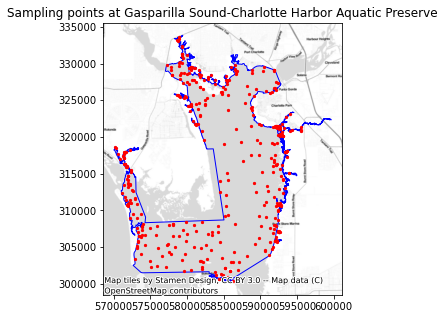

In [10]:
fig, ax = plt.subplots(figsize = (9,5))
extentShp.plot(ax = ax, color='none', edgecolor='blue')
gdfWetShp.plot(ax = ax, marker='o', color='red', markersize=5)
cx.add_basemap(ax = ax,source=cx.providers.Stamen.TonerLite,crs=gdfDryShp.crs)
ax.set_title('Sampling points at {}'.format(Area))

In [11]:
extent = str(extentShp.geometry.total_bounds).replace('[','').replace(']','')


# 4. Spatial Interpoation of Dissolved Oxygen <a class="anchor" id="do_interpolate"></a>

## 4.1 Ordinary Kriging: Dissolved Oxygen <a class="anchor" id="do_kriging"></a>

Run Oridinary Kriging for dry season data

In [325]:
year, season, method, value_field, mask = '2017', 'Dry','ok','ResultValu', gis_path+ '{}.shp'.format(b_name)
in_features = gis_path + season + year+Para_ab+'.shp'
out_ga_layer = gis_path +"{}{}{}.lyrx".format(Para_ab, season.lower(), method.upper())
out_raster = gis_path +"{}{}{}.tif".format(Para_ab, season.lower(),method.upper())

dryOK_2017, dryOKStat = misc.interpolation.interpolation(method = method, input_point = in_features, 
                      out_raster = out_raster, z_field = value_field, 
                      out_ga_layer = out_ga_layer, extent = extent, 
                      mask = mask)

season = 'Wet'
in_features = gis_path + season + year+Para_ab+'.shp'
out_ga_layer = gis_path +"{}{}{}.lyrx".format(Para_ab, season.lower(), method.upper())
out_raster = gis_path +"{}{}{}.tif".format(Para_ab, season.lower(),method.upper())

wetOK_2017,wetOKStat = misc.interpolation.interpolation(method = method, input_point = in_features, 
                      out_raster = out_raster, z_field = 'ResultValu', 
                      out_ga_layer = out_ga_layer, extent = extent, 
                      mask = mask)

Interpolation using the Ordinary Kriging method
Interpolation using the Ordinary Kriging method


Plot the interpolation result

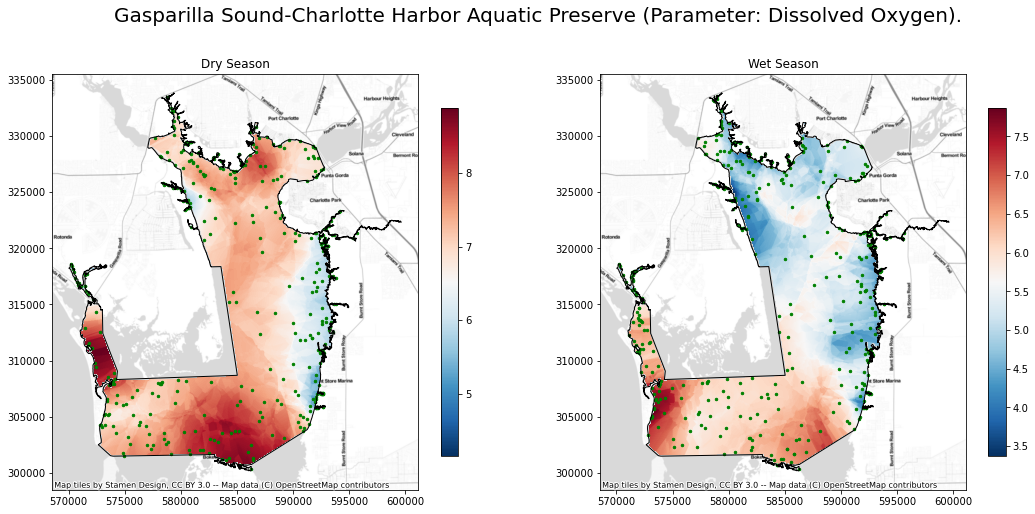

In [326]:
fig, axes = plt.subplots(1,2, figsize=(18, 8))

fig.suptitle("{} (Parameter: {}).".format(Area, Para),fontsize=20)

misc.interpolation.plot_raster(gdfDryShp, extentShp, dryOK_2017, 'Dry Season', axes[0], fig)
misc.interpolation.plot_raster(gdfWetShp, extentShp, wetOK_2017, 'Wet Season', axes[1], fig)

## 4.2 Inverse Distance Weighting (IDW): Dissolved Oxygen <a class="anchor" id="do_idw"></a>

Run IDW for both wet and dry seasons

In [327]:
year, season, method, value_field, mask = '2017', 'Dry','idw','ResultValu', gis_path+ '{}.shp'.format(b_name)
in_features = gis_path + season + year+Para_ab+'.shp'
out_ga_layer = gis_path +"{}{}{}.lyrx".format(Para_ab, season.lower(), method.upper())
out_raster = gis_path +"{}{}{}.tif".format(Para_ab, season.lower(),method.upper())

dryIDW_2017 = misc.interpolation.interpolation(method = method, input_point = in_features, 
                      out_raster = out_raster, z_field = value_field, 
                      out_ga_layer = out_ga_layer, extent = extent, 
                      mask = mask)

season = 'Wet'
in_features = gis_path + season + year+Para_ab+'.shp'
out_ga_layer = gis_path +"{}{}{}.lyrx".format(Para_ab, season.lower(), method.upper())
out_raster = gis_path +"{}{}{}.tif".format(Para_ab, season.lower(),method.upper())

wetIDW_2017 = misc.interpolation.interpolation(method = method, input_point = in_features, 
                      out_raster = gis_path +"{}{}{}.tif".format(Para_ab, season.lower(),method.upper()), z_field = 'ResultValu', 
                      out_ga_layer = gis_path +"{}{}{}.lyrx".format(Para_ab, season.lower(), method.upper()), extent = extent, 
                      mask = mask)

Interpolation using the Inverse Distance Weighting (IDW) method
--- Time lapse: 13.213399648666382 seconds ---
Interpolation using the Inverse Distance Weighting (IDW) method
--- Time lapse: 12.823824882507324 seconds ---


Plot the interpolation result

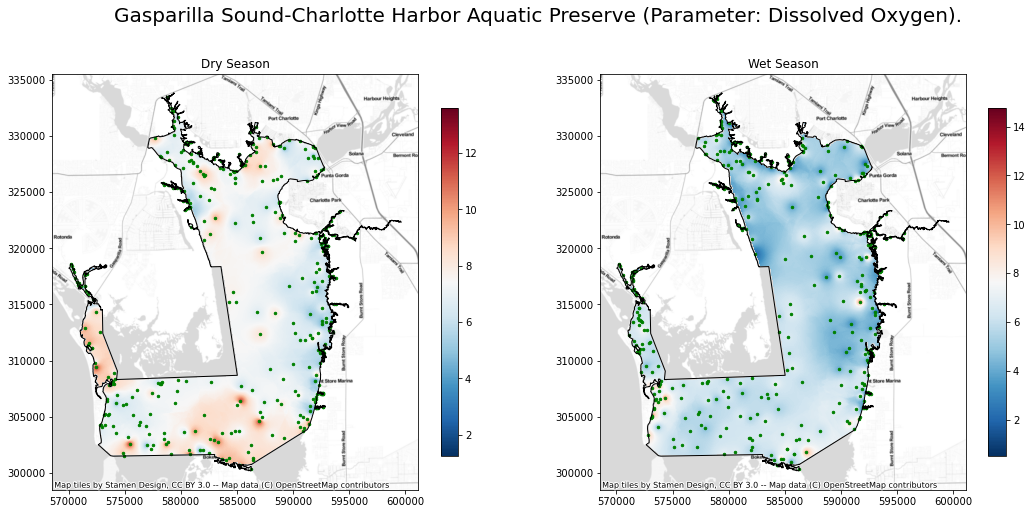

In [328]:
fig, axes = plt.subplots(1,2, figsize=(18, 8))

fig.suptitle("{} (Parameter: {}).".format(Area, Para),fontsize=20)

misc.interpolation.plot_raster(gdfDryShp, extentShp, dryIDW_2017, 'Dry Season', axes[0],fig)
misc.interpolation.plot_raster(gdfWetShp, extentShp, wetIDW_2017, 'Wet Season', axes[1],fig)


## 4.3 Empirical Bayesian Kriging (EBK) <a class="anchor" id="do_ebk"></a>

Run EBK for wet and dry seasons

In [329]:
year, season, method, value_field, mask = '2017', 'Dry','ebk','ResultValu', gis_path+ '{}.shp'.format(b_name)
in_features = gis_path + season + year+Para_ab+'.shp'
out_ga_layer = gis_path +"{}{}{}.lyrx".format(Para_ab, season.lower(), method.upper())
out_raster = gis_path +"{}{}{}.tif".format(Para_ab, season.lower(),method.upper())

dryEBK_2017 = misc.interpolation.interpolation(method = method, input_point = in_features, 
                      out_raster = out_raster, z_field = value_field, 
                      out_ga_layer = out_ga_layer, extent = extent, 
                      mask = mask)

season = 'Wet'
in_features = gis_path + season + year+Para_ab+'.shp'
out_ga_layer = gis_path +"{}{}{}.lyrx".format(Para_ab, season.lower(), method.upper())
out_raster = gis_path +"{}{}{}.tif".format(Para_ab, season.lower(),method.upper())

wetEBK_2017 = misc.interpolation.interpolation(method = method, input_point = in_features, 
                      out_raster = out_raster, z_field = 'ResultValu', out_ga_layer = out_ga_layer, extent = extent, mask = mask)

Interpolation using the Empirical Bayesian Kriging method
--- Time lapse: 275.701434135437 seconds ---
Interpolation using the Empirical Bayesian Kriging method
--- Time lapse: 240.65719056129456 seconds ---


Plot interpolation results

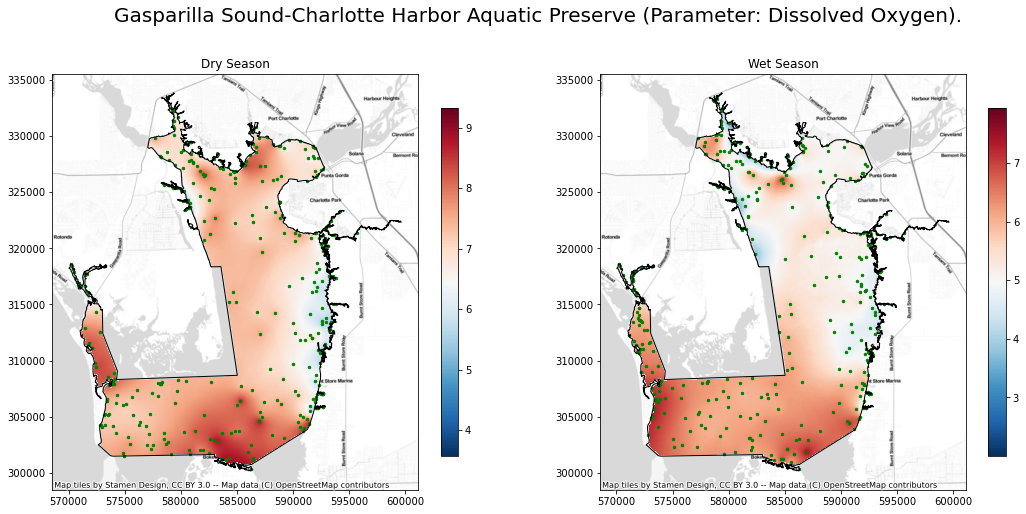

In [330]:
fig, axes = plt.subplots(1,2, figsize=(18, 8))

fig.suptitle("{} (Parameter: {}).".format(Area, Para),fontsize=20)

misc.interpolation.plot_raster(gdfDryShp, extentShp, dryEBK_2017, 'Dry Season', axes[0],fig)
misc.interpolation.plot_raster(gdfWetShp, extentShp, wetEBK_2017, 'Wet Season', axes[1],fig)


## 4.4 Regression Kriging (RK) <a class="anchor" id="do_rk"></a>

Plot the covariate (bathymetry)

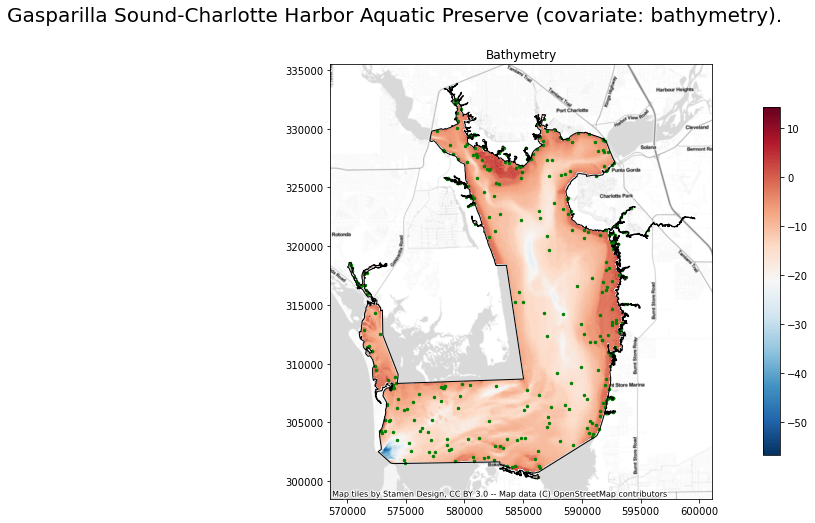

In [331]:
ma_table = pd.read_csv(gis_path + "MA_table.csv")
ra_fname = gis_path + "covariates/bathymetry/{}.tif".format(dictArea[Area])
#ra_fname = '{}.tif'.format(ma_table[ma_table['LONG_NAME']== Area]['MA_Name'].iloc[0].astype(str))
fig, ax = plt.subplots(1, figsize=(18, 8))

fig.suptitle("{} (covariate: {}).".format(Area, 'bathymetry'),fontsize=20)

gdfDryShp.plot(ax = ax, marker = 'o', color = 'green', markersize = 6)
extentShp.plot(ax = ax, color='none', edgecolor='black')
cx.add_basemap(ax = ax,source=cx.providers.Stamen.TonerLite,crs=gdfDryShp.crs)

#       Raster must added after basemap
with rasterio.open(ra_fname, "r+") as covar:
    band = covar.read(1)
    #band = numpy.ma.masked_array(band, mask=(band < -1000))
    #band = numpy.ma.masked_array(band, mask=(band > 1000))
    band = np.ma.masked_where((band < -100) | (band > 100), band)
    retted = rio_pl.show(band, transform=covar.transform, ax = ax, cmap="RdBu_r")
    ax.set_title('Bathymetry')
    # Add legend
    im = retted.get_images()[1]
    fig.colorbar(im, ax=ax,shrink=0.8)


Run regression kriging

In [332]:
year, season, method, value_field, mask = '2017', 'Dry','rk','ResultValu', gis_path+ '{}.shp'.format(b_name)
in_explanatory_rasters = gis_path + "covariates/bathymetry/{}.tif".format(dictArea[Area])

in_features = gis_path + season + year+Para_ab+'.shp'
out_ga_layer = gis_path +"{}{}{}.lyrx".format(Para_ab, season.lower(), method.upper())
out_raster = gis_path +"{}{}{}.tif".format(Para_ab, season.lower(),method.upper())

dryRK_2017 = misc.interpolation.interpolation(method = method, input_point = in_features, out_raster = out_raster, 
                                              z_field = value_field, out_ga_layer = out_ga_layer, extent = extent, 
                                              mask = mask, in_explanatory_rasters = in_explanatory_rasters)

season = 'Wet'
in_features = gis_path + season + year+Para_ab+'.shp'
out_ga_layer = gis_path +"{}{}{}.lyrx".format(Para_ab, season.lower(), method.upper())
out_raster = gis_path +"{}{}{}.tif".format(Para_ab, season.lower(),method.upper())

wetRK_2017 = misc.interpolation.interpolation(method = method, input_point = in_features, out_raster = out_raster, 
                                              z_field = 'ResultValu', out_ga_layer = out_ga_layer, extent = extent, 
                                              mask = mask, in_explanatory_rasters = in_explanatory_rasters)

Interpolation using the Regression Kriging method
--- Time lapse: 396.8195288181305 seconds ---
Interpolation using the Regression Kriging method
--- Time lapse: 399.1594843864441 seconds ---


Show interploation result

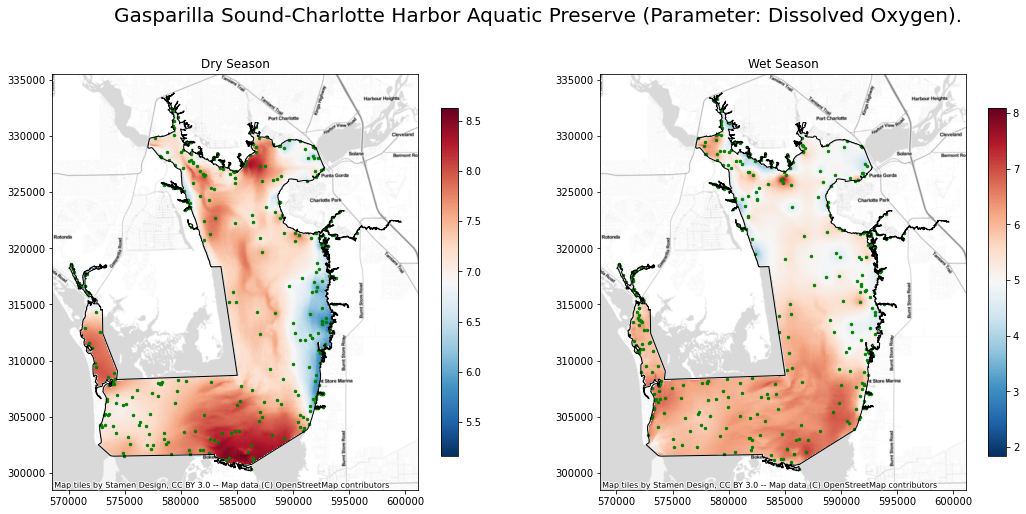

In [333]:
fig, axes = plt.subplots(1,2, figsize=(18, 8))

fig.suptitle("{} (Parameter: {}).".format(Area, Para),fontsize=20)

misc.interpolation.plot_raster(gdfDryShp, extentShp, dryRK_2017, 'Dry Season', axes[0],fig)
misc.interpolation.plot_raster(gdfWetShp, extentShp, wetRK_2017, 'Wet Season', axes[1],fig)

# 5. Interpolation Validation (Dissolved Oxygen) <a class="anchor" id="do_validation"></a>
## 5.1 Validation: Ordinary Kriging <a class="anchor" id="do_val_kriging"></a>

In [334]:
print("Interpolation assessment of Ordinary Kriging in dry season data")
display(dryOKStat)
print("Interpolation assessment of Ordinary Kriging in wet season data")
display(wetOKStat)

Interpolation assessment of Ordinary Kriging in dry season data


meanError  meanStandardizedError  rootMeanSquareError
Ordinary Kriging   0.055886               0.032848             1.636151

Interpolation assessment of Ordinary Kriging in wet season data


meanError  meanStandardizedError  rootMeanSquareError
Ordinary Kriging   0.012581               0.009202             1.830852

## 5.2 Validation: Inverse Distance Weighting (IDW) <a class="anchor" id="do_val_idw"></a>

In [335]:
#inLayer = gis_path+Para_ab + "dryIDW_GA.lyrx"
method, season = 'idw', 'dry'
inLayer = gis_path +"{}{}{}.lyrx".format(Para_ab, season.lower(), method.upper())
cvResult = arcpy.CrossValidation_ga(inLayer)
dryIDWStat = pd.DataFrame(
            {
              "meanError": round(float(cvResult.meanError),4),
#               "meanStandardizedError": round(float(cvResult.meanStandardized),4),
              "meanStandardizedError": "Nan",
              "rootMeanSquareError": round(float(cvResult.rootMeanSquare),4)
                                          },index=["Inverse Distance Weighting"])


method, season = 'idw', 'wet'
inLayer = gis_path +"{}{}{}.lyrx".format(Para_ab, season.lower(), method.upper())
cvResult = arcpy.CrossValidation_ga(inLayer)
wetIDWStat = pd.DataFrame(
            {
              "meanError": round(float(cvResult.meanError),4),
#               "meanStandardizedError": round(float(cvResult.meanStandardized),4),
              "meanStandardizedError": "Nan",
              "rootMeanSquareError": round(float(cvResult.rootMeanSquare),4)
                                          },index=["Inverse Distance Weighting"])

In [336]:
print("Interpolation assessment of Inverse Distance Weighting in dry season data")
display(dryIDWStat)
print("Interpolation assessment of Inverse Distance Weighting in wet season data")
display(wetIDWStat)

Interpolation assessment of Inverse Distance Weighting in dry season data


meanError meanStandardizedError  \
Inverse Distance Weighting     -0.069                   Nan   

                            rootMeanSquareError  
Inverse Distance Weighting                1.775

Interpolation assessment of Inverse Distance Weighting in wet season data


meanError meanStandardizedError  \
Inverse Distance Weighting     -0.049                   Nan   

                            rootMeanSquareError  
Inverse Distance Weighting               1.9753

## 5.3 Validation: Empirical Bayesian Kriging <a class="anchor" id="do_val_ebk"></a>

In [337]:
method, season = 'ebk', 'dry'
inLayer = gis_path +"{}{}{}.lyrx".format(Para_ab, season.lower(), method.upper())
cvResult = arcpy.CrossValidation_ga(inLayer)
dryEBKStat = pd.DataFrame(
            {
              "meanError": round(float(cvResult.meanError),4),
              "meanStandardizedError": round(float(cvResult.meanStandardized),4),
              "rootMeanSquareError": round(float(cvResult.rootMeanSquare),4)
                                          },index=["Empirical Bayesian Kriging"])


method, season = 'ebk', 'wet'
inLayer = gis_path +"{}{}{}.lyrx".format(Para_ab, season.lower(), method.upper())
cvResult = arcpy.CrossValidation_ga(inLayer)
wetEBKStat = pd.DataFrame(
            {
              "meanError": round(float(cvResult.meanError),4),
              "meanStandardizedError": round(float(cvResult.meanStandardized),4),
              "rootMeanSquareError": round(float(cvResult.rootMeanSquare),4)
                                          },index=["Empirical Bayesian Kriging"])

In [338]:
print("Interpolation assessment of Empirical Bayesian Kriging in dry season data")
display(dryEBKStat)
print("Interpolation assessment of Empirical Bayesian Kriging in wet season data")
display(wetEBKStat)

Interpolation assessment of Empirical Bayesian Kriging in dry season data


meanError  meanStandardizedError  \
Empirical Bayesian Kriging    -0.0077                -0.0014   

                            rootMeanSquareError  
Empirical Bayesian Kriging               1.5949

Interpolation assessment of Empirical Bayesian Kriging in wet season data


meanError  meanStandardizedError  \
Empirical Bayesian Kriging    -0.0079                -0.0036   

                            rootMeanSquareError  
Empirical Bayesian Kriging               1.7715

## 5.4 Validation: Regression Kriging <a class="anchor" id="do_val_rk"></a>

In [339]:
method, season = 'rk', 'dry'
inLayer = gis_path +"{}{}{}.lyrx".format(Para_ab, season.lower(), method.upper())
cvResult = arcpy.CrossValidation_ga(inLayer)
dryRKStat = pd.DataFrame(
            {
              "meanError": round(float(cvResult.meanError),4),
              "meanStandardizedError": round(float(cvResult.meanStandardized),4),
              "rootMeanSquareError": round(float(cvResult.rootMeanSquare),4)
                                          },index=["Regression Kriging"])


method, season = 'rk', 'wet'
inLayer = gis_path +"{}{}{}.lyrx".format(Para_ab, season.lower(), method.upper())
cvResult = arcpy.CrossValidation_ga(inLayer)
wetRKStat = pd.DataFrame(
            {
              "meanError": round(float(cvResult.meanError),4),
              "meanStandardizedError": round(float(cvResult.meanStandardized),4),
              "rootMeanSquareError": round(float(cvResult.rootMeanSquare),4)
                                          },index=["Regression Kriging"])

In [340]:
print("Interpolation assessment of Regression Kriging in dry season data")
display(dryRKStat)
print("Interpolation assessment of Regression Kriging in wet season data")
display(wetRKStat)

Interpolation assessment of Regression Kriging in dry season data


meanError  meanStandardizedError  rootMeanSquareError
Regression Kriging     0.0187                 0.0123               1.6154

Interpolation assessment of Regression Kriging in wet season data


meanError  meanStandardizedError  rootMeanSquareError
Regression Kriging      0.065                 0.0321               1.7821

## 5.5 Summary of Validation (comparing four methods) <a class="anchor" id="do_val_sum"></a>

In [341]:
sumStatDry   = pd.concat([dryOKStat,dryIDWStat,dryEBKStat,dryRKStat])
print("Summary of interpolation assessment in dry season data")
sumStatDry

Summary of interpolation assessment in dry season data


meanError meanStandardizedError  \
Ordinary Kriging             0.055886              0.032848   
Inverse Distance Weighting  -0.069000                   Nan   
Empirical Bayesian Kriging  -0.007700               -0.0014   
Regression Kriging           0.018700                0.0123   

                            rootMeanSquareError  
Ordinary Kriging                       1.636151  
Inverse Distance Weighting             1.775000  
Empirical Bayesian Kriging             1.594900  
Regression Kriging                     1.615400

In [342]:
sumStatWet = pd.concat([wetOKStat,wetIDWStat,wetEBKStat,wetRKStat])
print("Summary of interpolation assessment in wet season data")
sumStatWet

Summary of interpolation assessment in wet season data


meanError meanStandardizedError  \
Ordinary Kriging             0.012581              0.009202   
Inverse Distance Weighting  -0.049000                   Nan   
Empirical Bayesian Kriging  -0.007900               -0.0036   
Regression Kriging           0.065000                0.0321   

                            rootMeanSquareError  
Ordinary Kriging                       1.830852  
Inverse Distance Weighting             1.975300  
Empirical Bayesian Kriging             1.771500  
Regression Kriging                     1.782100

# 6. Spatial Interpolation of Salinity <a class="anchor" id="s_interpolate"></a>

In [343]:

# dfDis["timestamp"]=  pd.to_datetime(dfDis['SampleDate'])
# dfCon["timestamp"]=  pd.to_datetime(dfCon['SampleDate'])

# dfDryMean, gdfDryAll = combine_dis_con_dry(dfDis,dfCon,year)
# dfWetMean, gdfWetAll = combine_dis_con_wet(dfDis,dfCon,year)

Para, Para_ab, year = 'Salinity', 'S', '2017'

gdfDrySelect = gdfDryAll[(gdfDryAll["ParameterName"]==Para)&(gdfDryAll["ManagedAreaName"]==Area)]
gdfWetSelect = gdfWetAll[(gdfWetAll["ParameterName"]==Para)&(gdfWetAll["ManagedAreaName"]==Area)]

gdfDrySelect.to_crs(int(SpatialRef)).to_file(gis_path+"Dry"+year+Para_ab+'.shp', driver='ESRI Shapefile',crs="EPSG:"+SpatialRef)
gdfWetSelect.to_crs(int(SpatialRef)).to_file(gis_path+"Wet"+year+Para_ab+'.shp', driver='ESRI Shapefile',crs="EPSG:"+SpatialRef)

C:\Users\qiangy\AppData\Local\Temp\ipykernel_54280\1431908182.py:12: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdfDrySelect.to_crs(int(SpatialRef)).to_file(gis_path+"Dry"+year+Para_ab+'.shp', driver='ESRI Shapefile',crs="EPSG:"+SpatialRef)
C:\Users\qiangy\AppData\Local\Temp\ipykernel_54280\1431908182.py:13: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdfWetSelect.to_crs(int(SpatialRef)).to_file(gis_path+"Wet"+year+Para_ab+'.shp', driver='ESRI Shapefile',crs="EPSG:"+SpatialRef)


In [346]:
gdfDryShp = gpd.read_file(gis_path+"Dry"+year+Para_ab+'.shp')
gdfWetShp = gpd.read_file(gis_path+"Wet"+year+Para_ab+'.shp')
extentShp = gpd.read_file(gis_path+"ch.shp")

Text(0.5, 1.0, 'Sampling points at Gasparilla Sound-Charlotte Harbor Aquatic Preserve')

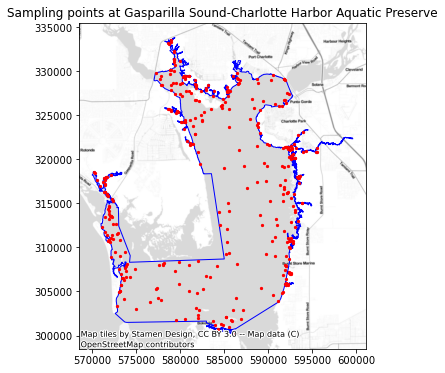

In [347]:
fig, ax = plt.subplots(figsize = (9,6))
extentShp.plot(ax = ax, color='none', edgecolor='blue')
gdfWetShp.plot(ax = ax, marker='o', color='red', markersize=5)
cx.add_basemap(ax = ax,source=cx.providers.Stamen.TonerLite,crs=gdfDryShp.crs)
ax.set_title('Sampling points at {}'.format(Area))

## 6.1 Ordinary Kriging (Salinity) <a class="anchor" id="s_ok"></a>

In [348]:
year, season, method, value_field, mask = '2017', 'Dry','ok','ResultValu', gis_path+ '{}.shp'.format(b_name)
in_features = gis_path + season + year+Para_ab+'.shp'
out_ga_layer = gis_path +"{}{}{}.lyrx".format(Para_ab, season.lower(), method.upper())
out_raster = gis_path +"{}{}{}.tif".format(Para_ab, season.lower(),method.upper())

dryOK_2017, dryOKStat = misc.interpolation.interpolation(method = method, input_point = in_features, out_raster = out_raster, 
                                                         z_field = value_field, out_ga_layer = out_ga_layer, extent = extent, mask = mask)

season = 'Wet'
in_features = gis_path + season + year+Para_ab+'.shp'
out_ga_layer = gis_path +"{}{}{}.lyrx".format(Para_ab, season.lower(), method.upper())
out_raster = gis_path +"{}{}{}.tif".format(Para_ab, season.lower(),method.upper())

wetOK_2017, wetOKStat = misc.interpolation.interpolation(method = method, input_point = in_features, out_raster = out_raster, 
                                                         z_field = value_field, out_ga_layer = out_ga_layer, extent = extent, mask = mask)

Interpolation using the Ordinary Kriging method
Interpolation using the Ordinary Kriging method


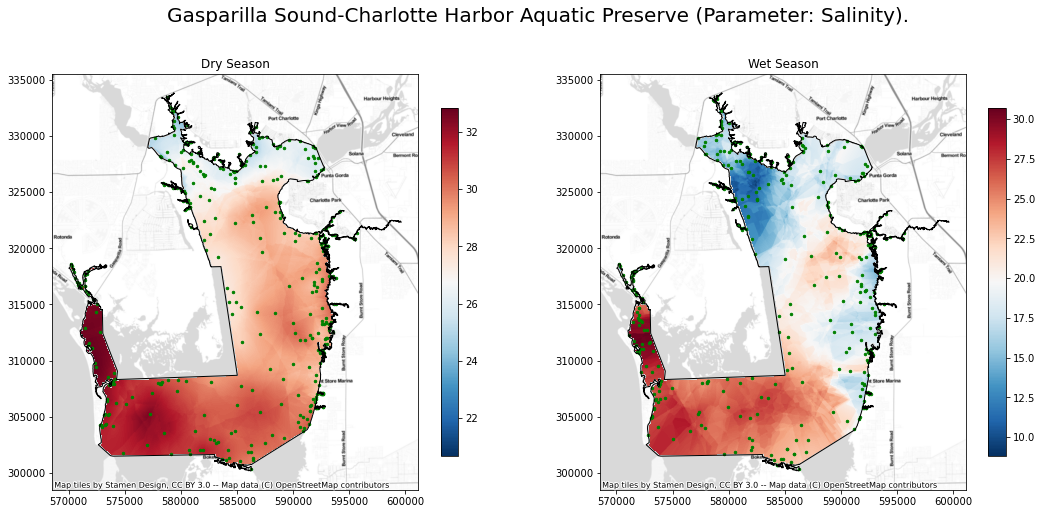

In [349]:
fig, axes = plt.subplots(1,2, figsize=(18, 8))

fig.suptitle("{} (Parameter: {}).".format(Area, Para),fontsize=20)

misc.interpolation.plot_raster(gdfDryShp, extentShp, dryOK_2017, 'Dry Season', axes[0], fig)
misc.interpolation.plot_raster(gdfWetShp, extentShp, wetOK_2017, 'Wet Season', axes[1], fig)

## 6.2 Inverse Distance Weighting (IDW): Salinity <a class="anchor" id="s_idw"></a>

Run IDW for both wet and dry seasons

In [350]:
year, season, method, value_field, mask = '2017', 'Dry','idw','ResultValu', gis_path+ '{}.shp'.format(b_name)
in_features = gis_path + season + year+Para_ab+'.shp'
out_ga_layer = gis_path +"{}{}{}.lyrx".format(Para_ab, season.lower(), method.upper())
out_raster = gis_path +"{}{}{}.tif".format(Para_ab, season.lower(),method.upper())

dryIDW_2017 = misc.interpolation.interpolation(method = method, input_point = in_features, out_raster = out_raster, 
                                               z_field = value_field, out_ga_layer = out_ga_layer, extent = extent, mask = mask)

season = 'Wet'
in_features = gis_path + season + year+Para_ab+'.shp'
out_ga_layer = gis_path +"{}{}{}.lyrx".format(Para_ab, season.lower(), method.upper())
out_raster = gis_path +"{}{}{}.tif".format(Para_ab, season.lower(),method.upper())

wetIDW_2017 = misc.interpolation.interpolation(method = method, input_point = in_features, out_raster = out_raster, 
                                               z_field = 'ResultValu', out_ga_layer = out_ga_layer, extent = extent, mask = mask)

Interpolation using the Inverse Distance Weighting (IDW) method
--- Time lapse: 13.015167474746704 seconds ---
Interpolation using the Inverse Distance Weighting (IDW) method
--- Time lapse: 13.260390281677246 seconds ---


Plot the interpolation result

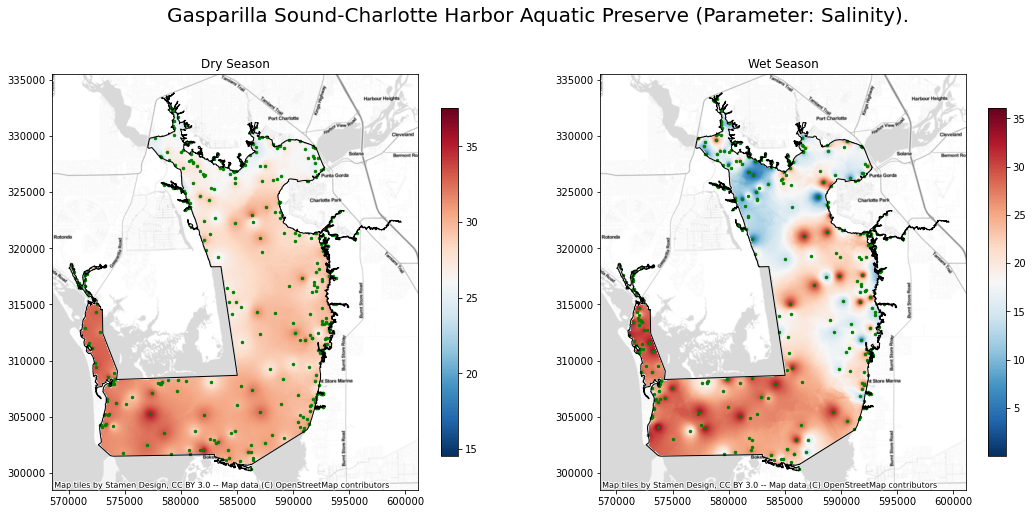

In [351]:
fig, axes = plt.subplots(1,2, figsize=(18, 8))

fig.suptitle("{} (Parameter: {}).".format(Area, Para),fontsize=20)

misc.interpolation.plot_raster(gdfDryShp, extentShp, dryIDW_2017, 'Dry Season', axes[0],fig)
misc.interpolation.plot_raster(gdfWetShp, extentShp, wetIDW_2017, 'Wet Season', axes[1],fig)

## 6.3 Empirical Bayesian Kriging (EBK): Salinity <a class="anchor" id="s_ebk"></a>

Run EBK for wet and dry seasons

In [352]:
year, season, method, value_field, mask = '2017', 'Dry','ebk','ResultValu', gis_path+ '{}.shp'.format(b_name)
in_features = gis_path + season + year+Para_ab+'.shp'
out_ga_layer = gis_path +"{}{}{}.lyrx".format(Para_ab, season.lower(), method.upper())
out_raster = gis_path +"{}{}{}.tif".format(Para_ab, season.lower(),method.upper())

dryEBK_2017 = misc.interpolation.interpolation(method = method, input_point = in_features, out_raster = out_raster, 
                                               z_field = value_field, out_ga_layer = out_ga_layer, extent = extent, mask = mask)

season = 'Wet'
in_features = gis_path + season + year+Para_ab+'.shp'
out_ga_layer = gis_path +"{}{}{}.lyrx".format(Para_ab, season.lower(), method.upper())
out_raster = gis_path +"{}{}{}.tif".format(Para_ab, season.lower(),method.upper())

wetEBK_2017 = misc.interpolation.interpolation(method = method, input_point = in_features, out_raster = out_raster, 
                                               z_field = 'ResultValu', out_ga_layer = out_ga_layer, extent = extent, mask = mask)

Interpolation using the Empirical Bayesian Kriging method
--- Time lapse: 266.81228613853455 seconds ---
Interpolation using the Empirical Bayesian Kriging method
--- Time lapse: 266.1738803386688 seconds ---


Plot interpolation results

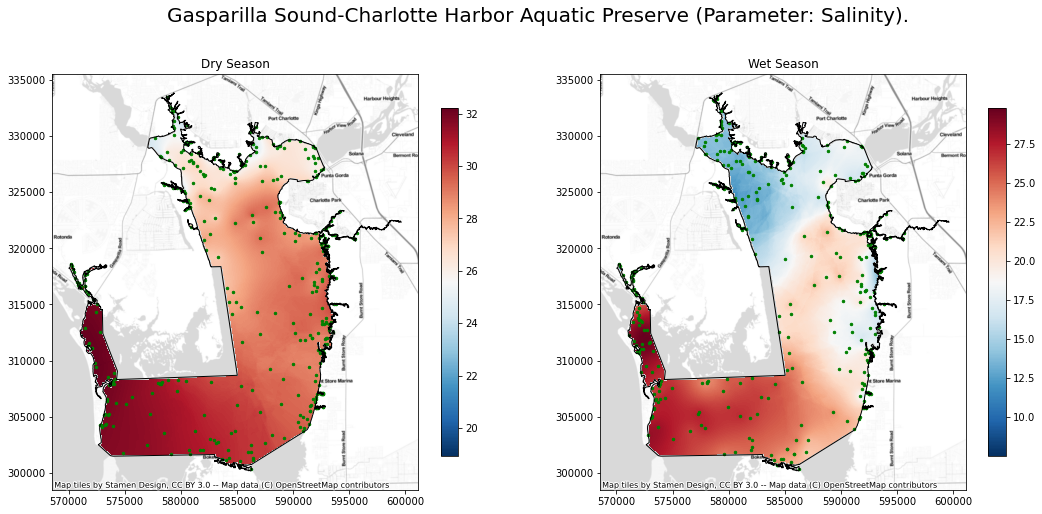

In [353]:
fig, axes = plt.subplots(1,2, figsize=(18, 8))

fig.suptitle("{} (Parameter: {}).".format(Area, Para),fontsize=20)

misc.interpolation.plot_raster(gdfDryShp, extentShp, dryEBK_2017, 'Dry Season', axes[0],fig)
misc.interpolation.plot_raster(gdfWetShp, extentShp, wetEBK_2017, 'Wet Season', axes[1],fig)

## 6.4 Regression Kriging (RK): Salinity <a class="anchor" id="s_rk"></a>

Display covariates

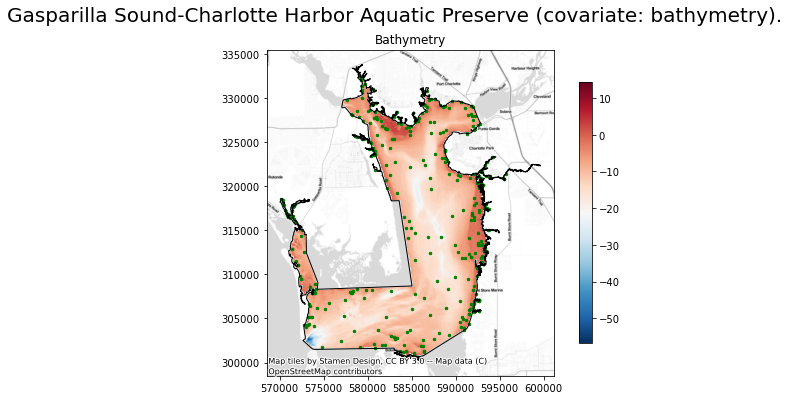

In [354]:
ma_table = pd.read_csv(gis_path + "MA_table.csv")
ra_fname = gis_path + "covariates/bathymetry/{}.tif".format(dictArea[Area])

fig, ax = plt.subplots(1, figsize=(9, 6))

fig.suptitle("{} (covariate: {}).".format(Area, 'bathymetry'),fontsize=20)

gdfDryShp.plot(ax = ax, marker = 'o', color = 'green', markersize = 6)
extentShp.plot(ax = ax, color='none', edgecolor='black')
cx.add_basemap(ax = ax,source=cx.providers.Stamen.TonerLite,crs=gdfDryShp.crs)

#       Raster must added after basemap
with rasterio.open(ra_fname, "r+") as covar:
    band = covar.read(1)
    #band = numpy.ma.masked_array(band, mask=(band < -1000))
    #band = numpy.ma.masked_array(band, mask=(band > 1000))
    band = np.ma.masked_where((band < -100) | (band > 100), band)
    retted = rio_pl.show(band, transform=covar.transform, ax = ax, cmap="RdBu_r")
    ax.set_title('Bathymetry')
    # Add legend
    im = retted.get_images()[1]
    fig.colorbar(im, ax=ax,shrink=0.8)


RK interpolation

In [355]:
year, season, method, value_field, mask = '2017', 'Dry','rk','ResultValu', gis_path+ '{}.shp'.format(b_name)
in_explanatory_rasters = gis_path + "covariates/bathymetry/{}.tif".format(dictArea[Area])

in_features = gis_path + season + year+Para_ab+'.shp'
out_ga_layer = gis_path +"{}{}{}.lyrx".format(Para_ab, season.lower(), method.upper())
out_raster = gis_path +"{}{}{}.tif".format(Para_ab, season.lower(),method.upper())

dryRK_2017 = misc.interpolation.interpolation(method = method, input_point = in_features, out_raster = out_raster, 
                                              z_field = value_field, out_ga_layer = out_ga_layer, extent = extent, 
                                              mask = mask, in_explanatory_rasters = in_explanatory_rasters)

season = 'Wet'
in_features = gis_path + season + year+Para_ab+'.shp'
out_ga_layer = gis_path +"{}{}{}.lyrx".format(Para_ab, season.lower(), method.upper())
out_raster = gis_path +"{}{}{}.tif".format(Para_ab, season.lower(),method.upper())

wetRK_2017 = misc.interpolation.interpolation(method = method, input_point = in_features, out_raster = out_raster, 
                                              z_field = 'ResultValu', out_ga_layer = out_ga_layer, extent = extent, 
                                              mask = mask, in_explanatory_rasters = in_explanatory_rasters)

Interpolation using the Regression Kriging method
--- Time lapse: 438.4331605434418 seconds ---
Interpolation using the Regression Kriging method
--- Time lapse: 408.24826312065125 seconds ---


Display result

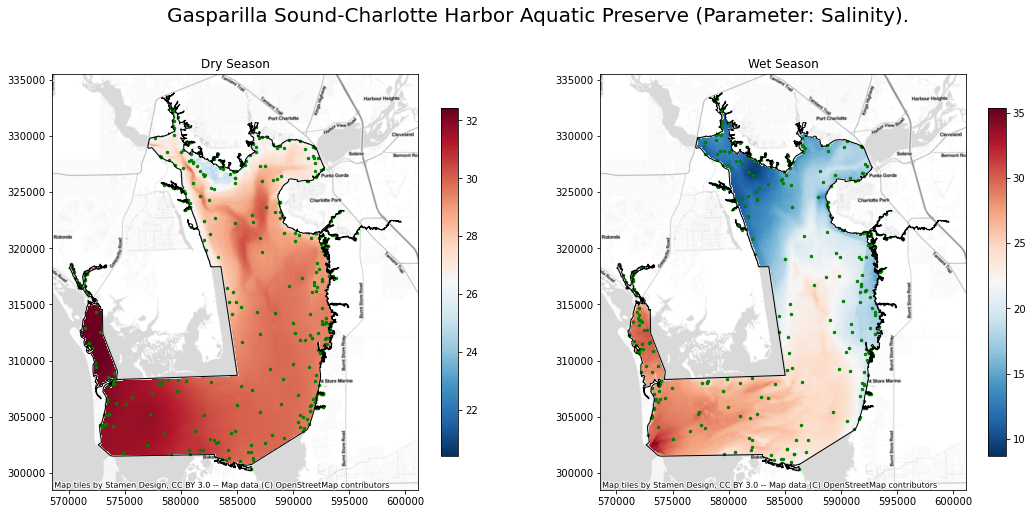

In [356]:
fig, axes = plt.subplots(1,2, figsize=(18, 8))

fig.suptitle("{} (Parameter: {}).".format(Area, Para),fontsize=20)

misc.interpolation.plot_raster(gdfDryShp, extentShp, dryRK_2017, 'Dry Season', axes[0],fig)
misc.interpolation.plot_raster(gdfWetShp, extentShp, wetRK_2017, 'Wet Season', axes[1],fig)

# 7. Interpolation Validation: Salinity <a class="anchor" id="s_validation"></a>
## 7.1 Validation of Ordinary Kriging <a class="anchor" id="s_val_ok"></a>

In [357]:
print("Interpolation assessment of Ordinary Kriging in dry season data")
display(dryOKStat)
print("Interpolation assessment of Ordinary Kriging in wet season data")
display(wetOKStat)

Interpolation assessment of Ordinary Kriging in dry season data


meanError  meanStandardizedError  rootMeanSquareError
Ordinary Kriging   0.043828               0.015356             2.620632

Interpolation assessment of Ordinary Kriging in wet season data


meanError  meanStandardizedError  rootMeanSquareError
Ordinary Kriging   0.146601               0.014534             9.245279

## 7.2 Validation of IDW: Salinity <a class="anchor" id="s_val_idw"></a>

In [358]:
method, season = 'idw', 'dry'
inLayer = gis_path +"{}{}{}.lyrx".format(Para_ab, season.lower(), method.upper())

cvResult = arcpy.CrossValidation_ga(inLayer)
dryIDWStat = pd.DataFrame(
            {
              "meanError": round(float(cvResult.meanError),4),
#               "meanStandardizedError": round(float(cvResult.meanStandardized),4),
              "meanStandardizedError": "Nan",
              "rootMeanSquareError": round(float(cvResult.rootMeanSquare),4)
                                          },index=["Inverse Distance Weighting"])


method, season = 'idw', 'wet'
inLayer = gis_path +"{}{}{}.lyrx".format(Para_ab, season.lower(), method.upper())

cvResult = arcpy.CrossValidation_ga(inLayer)
wetIDWStat = pd.DataFrame(
            {
              "meanError": round(float(cvResult.meanError),4),
#               "meanStandardizedError": round(float(cvResult.meanStandardized),4),
              "meanStandardizedError": "Nan",
              "rootMeanSquareError": round(float(cvResult.rootMeanSquare),4)
                                          },index=["Inverse Distance Weighting"])

In [359]:
print("Interpolation assessment of Inverse Distance Weighting in dry season data")
display(dryIDWStat)
print("Interpolation assessment of Inverse Distance Weighting in wet season data")
display(wetIDWStat)

Interpolation assessment of Inverse Distance Weighting in dry season data


meanError meanStandardizedError  \
Inverse Distance Weighting    -0.1179                   Nan   

                            rootMeanSquareError  
Inverse Distance Weighting               2.9739

Interpolation assessment of Inverse Distance Weighting in wet season data


meanError meanStandardizedError  \
Inverse Distance Weighting    -0.1302                   Nan   

                            rootMeanSquareError  
Inverse Distance Weighting              10.3147

## 7.3 Validation of Empirical Bayesian Kriging: Salinity <a class="anchor" id="s_val_ebk"></a>

In [360]:
method, season = 'ebk', 'dry'
inLayer = gis_path +"{}{}{}.lyrx".format(Para_ab, season.lower(), method.upper())

cvResult = arcpy.CrossValidation_ga(inLayer)
dryEBKStat = pd.DataFrame(
            {
              "meanError": round(float(cvResult.meanError),4),
              "meanStandardizedError": round(float(cvResult.meanStandardized),4),
              "rootMeanSquareError": round(float(cvResult.rootMeanSquare),4)
                                          },index=["Empirical Bayesian Kriging"])


method, season = 'ebk', 'wet'
inLayer = gis_path +"{}{}{}.lyrx".format(Para_ab, season.lower(), method.upper())

cvResult = arcpy.CrossValidation_ga(inLayer)
wetEBKStat = pd.DataFrame(
            {
              "meanError": round(float(cvResult.meanError),4),
              "meanStandardizedError": round(float(cvResult.meanStandardized),4),
              "rootMeanSquareError": round(float(cvResult.rootMeanSquare),4)
                                          },index=["Empirical Bayesian Kriging"])

In [361]:
print("Interpolation assessment of Empirical Bayesian Kriging in dry season data")
display(dryEBKStat)
print("Interpolation assessment of Empirical Bayesian Kriging in wet season data")
display(wetEBKStat)

Interpolation assessment of Empirical Bayesian Kriging in dry season data


meanError  meanStandardizedError  \
Empirical Bayesian Kriging    -0.0242                -0.0106   

                            rootMeanSquareError  
Empirical Bayesian Kriging                2.548

Interpolation assessment of Empirical Bayesian Kriging in wet season data


meanError  meanStandardizedError  \
Empirical Bayesian Kriging    -0.0377                -0.0042   

                            rootMeanSquareError  
Empirical Bayesian Kriging               8.9248

## 7.4 Validation of Regression Kriging: Salinity <a class="anchor" id="s_val_rk"></a>

In [362]:
method, season = 'rk', 'dry'
inLayer = gis_path +"{}{}{}.lyrx".format(Para_ab, season.lower(), method.upper())

cvResult = arcpy.CrossValidation_ga(inLayer)
dryRKStat = pd.DataFrame(
            {
              "meanError": round(float(cvResult.meanError),4),
              "meanStandardizedError": round(float(cvResult.meanStandardized),4),
              "rootMeanSquareError": round(float(cvResult.rootMeanSquare),4)
                                          },index=["Regression Kriging"])


method, season = 'rk', 'wet'
inLayer = gis_path +"{}{}{}.lyrx".format(Para_ab, season.lower(), method.upper())

cvResult = arcpy.CrossValidation_ga(inLayer)
wetRKStat = pd.DataFrame(
            {
              "meanError": round(float(cvResult.meanError),4),
              "meanStandardizedError": round(float(cvResult.meanStandardized),4),
              "rootMeanSquareError": round(float(cvResult.rootMeanSquare),4)
                                          },index=["Regression Kriging"])

In [363]:
print("Interpolation assessment of Regression Kriging in dry season data")
display(dryRKStat)
print("Interpolation assessment of Regression Kriging in wet season data")
display(wetRKStat)

Interpolation assessment of Regression Kriging in dry season data


meanError  meanStandardizedError  rootMeanSquareError
Regression Kriging    -0.0399                -0.0222               2.5193

Interpolation assessment of Regression Kriging in wet season data


meanError  meanStandardizedError  rootMeanSquareError
Regression Kriging      0.007                 -0.005               8.8481

## 7.5 Validation Summary: Salinity <a class="anchor" id="s_val_sum"></a>

In [364]:
sumStatDry2 = pd.concat([dryOKStat,dryIDWStat, dryEBKStat,dryRKStat])

print("Summary of interpolation assessment in dry season data")
sumStatDry2

Summary of interpolation assessment in dry season data


meanError meanStandardizedError  \
Ordinary Kriging             0.043828              0.015356   
Inverse Distance Weighting  -0.117900                   Nan   
Empirical Bayesian Kriging  -0.024200               -0.0106   
Regression Kriging          -0.039900               -0.0222   

                            rootMeanSquareError  
Ordinary Kriging                       2.620632  
Inverse Distance Weighting             2.973900  
Empirical Bayesian Kriging             2.548000  
Regression Kriging                     2.519300

In [365]:
sumStatWet2 = pd.concat([wetOKStat,wetIDWStat, wetEBKStat,wetRKStat])

print("Summary of interpolation assessment in dry season data")
sumStatWet2

Summary of interpolation assessment in dry season data


meanError meanStandardizedError  \
Ordinary Kriging             0.146601              0.014534   
Inverse Distance Weighting  -0.130200                   Nan   
Empirical Bayesian Kriging  -0.037700               -0.0042   
Regression Kriging           0.007000                -0.005   

                            rootMeanSquareError  
Ordinary Kriging                       9.245279  
Inverse Distance Weighting            10.314700  
Empirical Bayesian Kriging             8.924800  
Regression Kriging                     8.848100

# 8. Spatial Interpolation of Total Nitrogen <a class="anchor" id="tn_interpolate"></a>
## 8.1 Ordinary Kriging: Total Nitrogen <a class="anchor" id="tn_kriging"></a>

In [366]:
year,Para,Para_ab = "2014", 'Total Nitrogen', "TN"

dfDryMean, gdfDryAll = misc.preprocess.combine_dis_con_dry(dfDis,dfCon,year)
dfWetMean, gdfWetAll = misc.preprocess.combine_dis_con_wet(dfDis,dfCon,year)

gdfDryAll.to_csv(gis_path+'gdfDryAll{}.csv'.format(year))
gdfWetAll.to_csv(gis_path+'gdfWetAll{}.csv'.format(year))

gdfDrySelect = gdfDryAll[(gdfDryAll["ParameterName"]==Para)&(gdfDryAll["ManagedAreaName"]==Area)]
gdfWetSelect = gdfWetAll[(gdfWetAll["ParameterName"]==Para)&(gdfWetAll["ManagedAreaName"]==Area)]

gdfDrySelect.to_crs(int(SpatialRef)).to_file(gis_path+"Dry"+year+Para_ab+'.shp', driver='ESRI Shapefile',crs="EPSG:"+SpatialRef)
gdfWetSelect.to_crs(int(SpatialRef)).to_file(gis_path+"Wet"+year+Para_ab+'.shp', driver='ESRI Shapefile',crs="EPSG:"+SpatialRef)

C:\Users\qiangy\AppData\Local\Temp\ipykernel_54280\1632681457.py:12: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdfDrySelect.to_crs(int(SpatialRef)).to_file(gis_path+"Dry"+year+Para_ab+'.shp', driver='ESRI Shapefile',crs="EPSG:"+SpatialRef)
C:\Users\qiangy\AppData\Local\Temp\ipykernel_54280\1632681457.py:13: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdfWetSelect.to_crs(int(SpatialRef)).to_file(gis_path+"Wet"+year+Para_ab+'.shp', driver='ESRI Shapefile',crs="EPSG:"+SpatialRef)


In [367]:
gdfDryShp = gpd.read_file(gis_path+"Dry"+year+Para_ab+'.shp')
gdfWetShp = gpd.read_file(gis_path+"Wet"+year+Para_ab+'.shp')
extentShp = gpd.read_file(gis_path+ '{}.shp'.format(b_name))

Text(0.5, 1.0, 'Sampling points at Gasparilla Sound-Charlotte Harbor Aquatic Preserve')

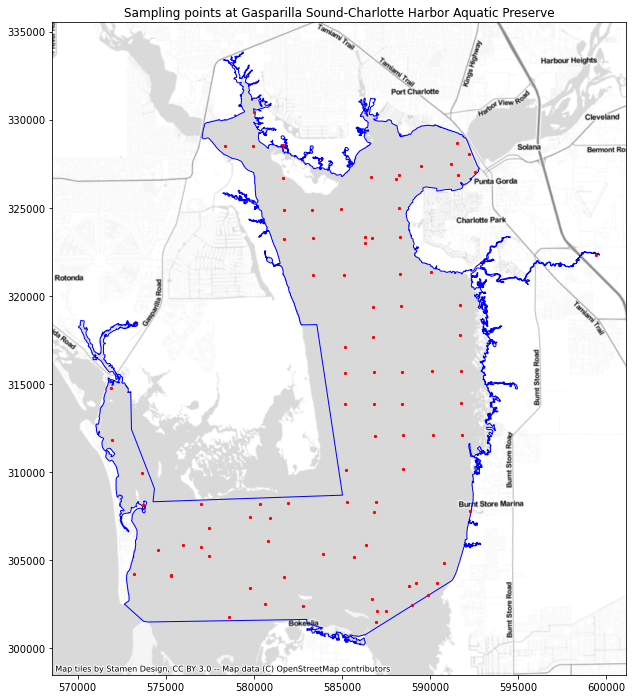

In [368]:
fig, ax = plt.subplots(figsize = (16,12))
extentShp.plot(ax = ax, color='none', edgecolor='blue')
gdfWetShp.plot(ax = ax, marker='o', color='red', markersize=5)
cx.add_basemap(ax = ax,source=cx.providers.Stamen.TonerLite,crs=gdfDryShp.crs)
ax.set_title('Sampling points at {}'.format(Area))

## 8.1 Ordinary Kriging: Total Nitrogen <a class="anchor" id="tn_kriging"></a>

In [369]:
year, season, method, value_field, mask = '2014', 'Dry','ok','ResultValu', gis_path+ '{}.shp'.format(b_name)
in_features = gis_path + season + year+Para_ab+'.shp'
out_ga_layer = gis_path +"{}{}{}.lyrx".format(Para_ab, season.lower(), method.upper())
out_raster = gis_path +"{}{}{}.tif".format(Para_ab, season.lower(),method.upper())

dryOK_2014, dryOKStat = misc.interpolation.interpolation(method = method, input_point = in_features, 
                      out_raster = out_raster, z_field = value_field, 
                      out_ga_layer = out_ga_layer, extent = extent, 
                      mask = mask)

season = 'Wet'
wetOK_2014,wetOKStat = misc.interpolation.interpolation(method = method, input_point = gis_path + season + year+Para_ab+'.shp', 
                      out_raster = gis_path +"{}{}{}.tif".format(Para_ab, season.lower(),method.upper()), z_field = 'ResultValu', 
                      out_ga_layer = gis_path +"{}{}{}.lyrx".format(Para_ab, season.lower(), method.upper()), extent = extent, 
                      mask = mask)

Interpolation using the Ordinary Kriging method
Interpolation using the Ordinary Kriging method


C:\Users\qiangy\AppData\Local\ESRI\conda\envs\geo3\lib\site-packages\matplotlib\image.py:487: RuntimeWarning: overflow encountered in true_divide
  A_scaled /= ((a_max - a_min) / frac)


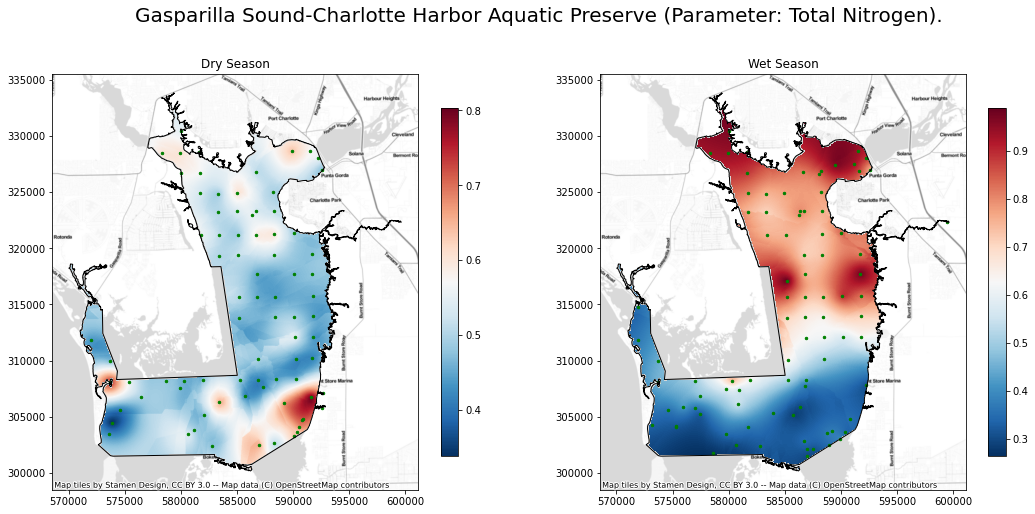

In [370]:
fig, axes = plt.subplots(1,2, figsize=(18, 8))

fig.suptitle("{} (Parameter: {}).".format(Area, Para),fontsize=20)

misc.interpolation.plot_raster(gdfDryShp, extentShp, dryOK_2014, 'Dry Season', axes[0], fig)
misc.interpolation.plot_raster(gdfWetShp, extentShp, wetOK_2014, 'Wet Season', axes[1], fig)

## 8.2 Inverse Distance Weighting: Total Nitrogen <a class="anchor" id="tn_idw"></a>

In [371]:
year, season, method, value_field, mask = '2014', 'Dry','idw','ResultValu', gis_path+ '{}.shp'.format(b_name)
in_features = gis_path + season + year+Para_ab+'.shp'
out_ga_layer = gis_path +"{}{}{}.lyrx".format(Para_ab, season.lower(), method.upper())
out_raster = gis_path +"{}{}{}.tif".format(Para_ab, season.lower(),method.upper())

dryIDW_2014 = misc.interpolation.interpolation(method = method, input_point = in_features, 
                      out_raster = out_raster, z_field = value_field, 
                      out_ga_layer = out_ga_layer, extent = extent, 
                      mask = mask)

season = 'Wet'
wetIDW_2014 = misc.interpolation.interpolation(method = method, input_point = gis_path + season + year+Para_ab+'.shp', 
                      out_raster = gis_path +"{}{}{}.tif".format(Para_ab, season.lower(),method.upper()), z_field = 'ResultValu', 
                      out_ga_layer = gis_path +"{}{}{}.lyrx".format(Para_ab, season.lower(), method.upper()), extent = extent, 
                      mask = mask)


Interpolation using the Inverse Distance Weighting (IDW) method
--- Time lapse: 34.3053343296051 seconds ---
Interpolation using the Inverse Distance Weighting (IDW) method
--- Time lapse: 29.965927839279175 seconds ---


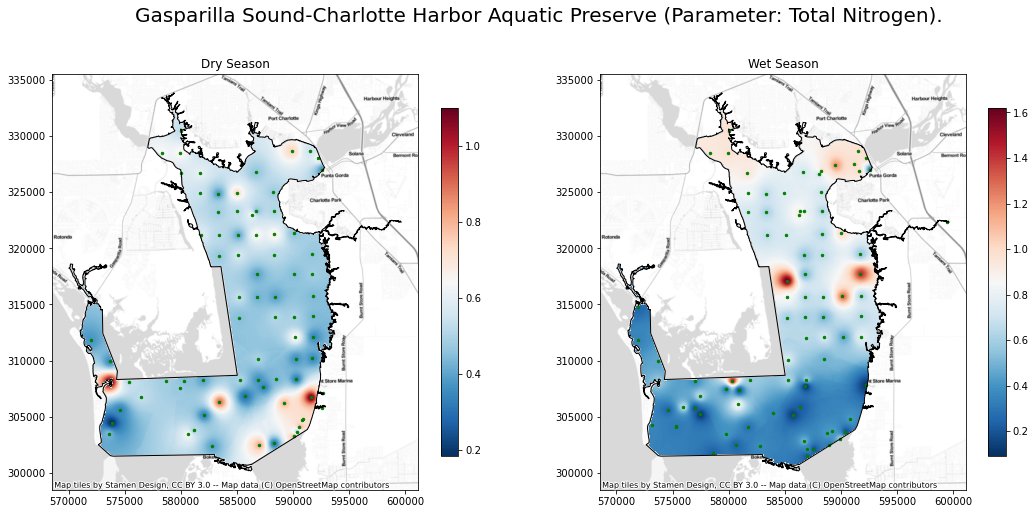

In [372]:
fig, axes = plt.subplots(1,2, figsize=(18, 8))

fig.suptitle("{} (Parameter: {}).".format(Area, Para),fontsize=20)

misc.interpolation.plot_raster(gdfDryShp, extentShp, dryIDW_2014, 'Dry Season', axes[0],fig)
misc.interpolation.plot_raster(gdfWetShp, extentShp, wetIDW_2014, 'Wet Season', axes[1],fig)

## 8.3 Empirical Bayesian Kriging: Total Nitrogen <a class="anchor" id="tn_ebk"></a>

In [373]:
year, season, method, value_field, mask = '2014', 'Dry','ebk','ResultValu', gis_path+ '{}.shp'.format(b_name)
in_features = gis_path + season + year+Para_ab+'.shp'
out_ga_layer = gis_path +"{}{}{}.lyrx".format(Para_ab, season.lower(), method.upper())
out_raster = gis_path +"{}{}{}.tif".format(Para_ab, season.lower(),method.upper())

dryEBK_2014 = misc.interpolation.interpolation(method = method, input_point = in_features, 
                      out_raster = out_raster, z_field = value_field, 
                      out_ga_layer = out_ga_layer, extent = extent, 
                      mask = mask)

season = 'Wet'
wetEBK_2014 = misc.interpolation.interpolation(method = method, input_point = gis_path + season + year+Para_ab+'.shp', 
                      out_raster = gis_path +"{}{}{}.tif".format(Para_ab, season.lower(),method.upper()), z_field = 'ResultValu', 
                      out_ga_layer = gis_path +"{}{}{}.lyrx".format(Para_ab, season.lower(), method.upper()), extent = extent, 
                      mask = mask)

Interpolation using the Empirical Bayesian Kriging method
--- Time lapse: 250.94046330451965 seconds ---
Interpolation using the Empirical Bayesian Kriging method
--- Time lapse: 218.69562458992004 seconds ---


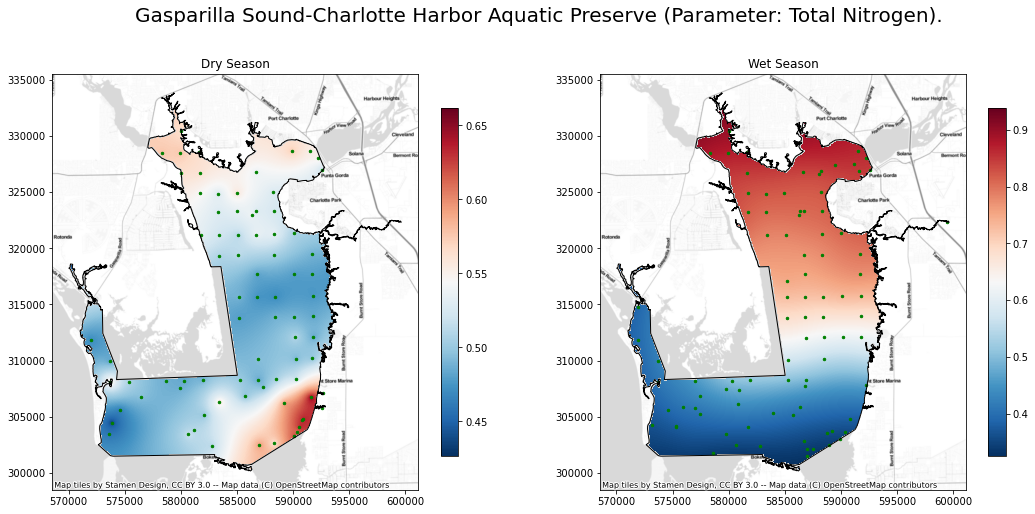

In [374]:
fig, axes = plt.subplots(1,2, figsize=(18, 8))

fig.suptitle("{} (Parameter: {}).".format(Area, Para),fontsize=20)

misc.interpolation.plot_raster(gdfDryShp, extentShp, dryEBK_2014, 'Dry Season', axes[0],fig)
misc.interpolation.plot_raster(gdfWetShp, extentShp, wetEBK_2014, 'Wet Season', axes[1],fig)

## 8.4 Regression Kriging: Total Nitrogen <a class="anchor" id="tn_rk"></a>

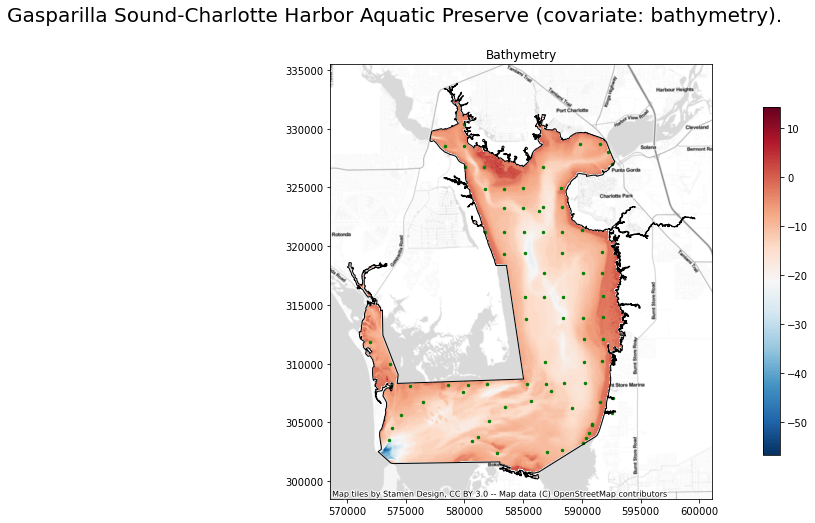

In [375]:
ma_table = pd.read_csv(gis_path + "MA_table.csv")
ra_fname = gis_path + "covariates/bathymetry/{}.tif".format(dictArea[Area])
fig, ax = plt.subplots(1, figsize=(18, 8))

fig.suptitle("{} (covariate: {}).".format(Area, 'bathymetry'),fontsize=20)

gdfDryShp.plot(ax = ax, marker = 'o', color = 'green', markersize = 6)
extentShp.plot(ax = ax, color='none', edgecolor='black')
cx.add_basemap(ax = ax,source=cx.providers.Stamen.TonerLite,crs=gdfDryShp.crs)

#       Raster must added after basemap
with rasterio.open(ra_fname, "r+") as covar:
    band = covar.read(1)
    #band = numpy.ma.masked_array(band, mask=(band < -1000))
    #band = numpy.ma.masked_array(band, mask=(band > 1000))
    band = np.ma.masked_where((band < -100) | (band > 100), band)
    retted = rio_pl.show(band, transform=covar.transform, ax = ax, cmap="RdBu_r")
    ax.set_title('Bathymetry')
    # Add legend
    im = retted.get_images()[1]
    fig.colorbar(im, ax=ax,shrink=0.8)

In [376]:
year, season, method, value_field, mask = '2014', 'Dry','rk','ResultValu', gis_path+ '{}.shp'.format(b_name)
in_explanatory_rasters = gis_path + "covariates/{}".format('NCEI_DEM_30m.tif')

in_features = gis_path + season + year+Para_ab+'.shp'
out_ga_layer = gis_path +"{}{}{}.lyrx".format(Para_ab, season.lower(), method.upper())
out_raster = gis_path +"{}{}{}.tif".format(Para_ab, season.lower(),method.upper())

dryRK_2014 = misc.interpolation.interpolation(method = method, input_point = in_features, 
                      out_raster = out_raster, z_field = value_field, 
                      out_ga_layer = out_ga_layer, extent = extent, 
                      mask = mask, in_explanatory_rasters = in_explanatory_rasters)

season = 'Wet'
in_features = gis_path + season + year+Para_ab+'.shp'
out_ga_layer = gis_path +"{}{}{}.lyrx".format(Para_ab, season.lower(), method.upper())
out_raster = gis_path +"{}{}{}.tif".format(Para_ab, season.lower(),method.upper())
                                              
wetRK_2014 = misc.interpolation.interpolation(method = method, input_point = in_features, 
                      out_raster = out_raster, z_field = 'ResultValu', 
                      out_ga_layer = out_ga_layer, extent = extent, 
                      mask = mask, in_explanatory_rasters = in_explanatory_rasters)

Interpolation using the Regression Kriging method
--- Time lapse: 205.06006169319153 seconds ---
Interpolation using the Regression Kriging method
--- Time lapse: 219.98517894744873 seconds ---


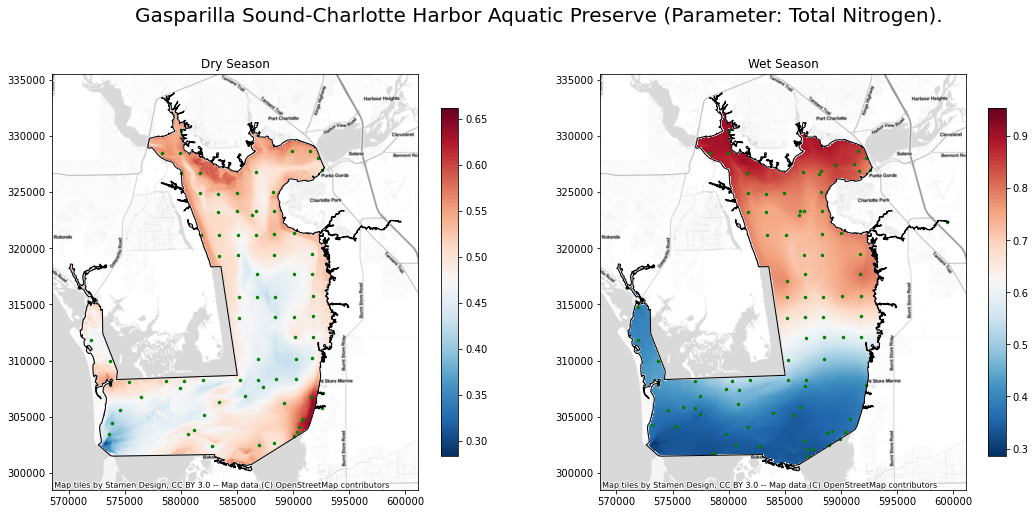

In [377]:
fig, axes = plt.subplots(1,2, figsize=(18, 8))

fig.suptitle("{} (Parameter: {}).".format(Area, Para),fontsize=20)

misc.interpolation.plot_raster(gdfDryShp, extentShp, dryRK_2014, 'Dry Season', axes[0],fig)
misc.interpolation.plot_raster(gdfWetShp, extentShp, wetRK_2014, 'Wet Season', axes[1],fig)

# 9. Validation of Interpolation: Total Nitrogen <a class="anchor" id="tn_validation"></a>
## 9.1. Validation of Ordinary Kriging: Total Nitrogen <a class="anchor" id="tn_val_ok"></a>


In [378]:
print("Interpolation assessment of Ordinary Kriging in dry season data")
display(dryOKStat)
print("Interpolation assessment of Ordinary Kriging in wet season data")
display(wetOKStat)

Interpolation assessment of Ordinary Kriging in dry season data


meanError  meanStandardizedError  rootMeanSquareError
Ordinary Kriging   0.002538               0.015177             0.170899

Interpolation assessment of Ordinary Kriging in wet season data


meanError  meanStandardizedError  rootMeanSquareError
Ordinary Kriging  -0.001186               -0.00574             0.248615

## 9.2. Validation of IDW: Total Nitrogen <a class="anchor" id="tn_val_idw"></a>


In [379]:
method, season = 'idw', 'dry'
inLayer = gis_path +"{}{}{}.lyrx".format(Para_ab, season.lower(), method.upper())

cvResult = arcpy.CrossValidation_ga(inLayer)
dryIDWStat = pd.DataFrame(
            {
              "meanError": round(float(cvResult.meanError),4),
#               "meanStandardizedError": round(float(cvResult.meanStandardized),4),
              "meanStandardizedError": "Nan",
              "rootMeanSquareError": round(float(cvResult.rootMeanSquare),4)
                                          },index=["Inverse Distance Weighting"])


method, season = 'idw', 'wet'
inLayer = gis_path +"{}{}{}.lyrx".format(Para_ab, season.lower(), method.upper())

cvResult = arcpy.CrossValidation_ga(inLayer)
wetIDWStat = pd.DataFrame(
            {
              "meanError": round(float(cvResult.meanError),4),
#               "meanStandardizedError": round(float(cvResult.meanStandardized),4),
              "meanStandardizedError": "Nan",
              "rootMeanSquareError": round(float(cvResult.rootMeanSquare),4)
                                          },index=["Inverse Distance Weighting"])

In [380]:
print("Interpolation assessment of Inverse Distance Weighting in dry season data")
display(dryIDWStat)
print("Interpolation assessment of Inverse Distance Weighting in wet season data")
display(wetIDWStat)

Interpolation assessment of Inverse Distance Weighting in dry season data


meanError meanStandardizedError  \
Inverse Distance Weighting     0.0012                   Nan   

                            rootMeanSquareError  
Inverse Distance Weighting               0.1715

Interpolation assessment of Inverse Distance Weighting in wet season data


meanError meanStandardizedError  \
Inverse Distance Weighting     0.0018                   Nan   

                            rootMeanSquareError  
Inverse Distance Weighting               0.2691

## 9.3. Validation of Empirical Bayesian Kriging: Total Nitrogen <a class="anchor" id="tn_val_ebk"></a>


In [381]:
method, season = 'ebk', 'dry'
inLayer = gis_path +"{}{}{}.lyrx".format(Para_ab, season.lower(), method.upper())

cvResult = arcpy.CrossValidation_ga(inLayer)
dryEBKStat = pd.DataFrame(
            {
              "meanError": round(float(cvResult.meanError),4),
              "meanStandardizedError": round(float(cvResult.meanStandardized),4),
              "rootMeanSquareError": round(float(cvResult.rootMeanSquare),4)
                                          },index=["Empirical Bayesian Kriging"])


method, season = 'ebk', 'wet'
inLayer = gis_path +"{}{}{}.lyrx".format(Para_ab, season.lower(), method.upper())

cvResult = arcpy.CrossValidation_ga(inLayer)
wetEBKStat = pd.DataFrame(
            {
              "meanError": round(float(cvResult.meanError),4),
              "meanStandardizedError": round(float(cvResult.meanStandardized),4),
              "rootMeanSquareError": round(float(cvResult.rootMeanSquare),4)
                                          },index=["Empirical Bayesian Kriging"])

In [382]:
print("Interpolation assessment of Empirical Bayesian Kriging in dry season data")
display(dryEBKStat)
print("Interpolation assessment of Empirical Bayesian Kriging in wet season data")
display(wetEBKStat)

Interpolation assessment of Empirical Bayesian Kriging in dry season data


meanError  meanStandardizedError  \
Empirical Bayesian Kriging    -0.0022                 -0.014   

                            rootMeanSquareError  
Empirical Bayesian Kriging               0.1625

Interpolation assessment of Empirical Bayesian Kriging in wet season data


meanError  meanStandardizedError  \
Empirical Bayesian Kriging    -0.0028                 -0.012   

                            rootMeanSquareError  
Empirical Bayesian Kriging               0.2437

## 9.4. Validation of Regression Kriging: Total Nitrogen <a class="anchor" id="tn_val_rk"></a>

In [383]:
method, season = 'rk', 'dry'
inLayer = gis_path +"{}{}{}.lyrx".format(Para_ab, season.lower(), method.upper())

cvResult = arcpy.CrossValidation_ga(inLayer)
dryRKStat = pd.DataFrame(
            {
              "meanError": round(float(cvResult.meanError),4),
              "meanStandardizedError": round(float(cvResult.meanStandardized),4),
              "rootMeanSquareError": round(float(cvResult.rootMeanSquare),4)
                                          },index=["Regression Kriging"])


method, season = 'rk', 'wet'
inLayer = gis_path +"{}{}{}.lyrx".format(Para_ab, season.lower(), method.upper())

cvResult = arcpy.CrossValidation_ga(inLayer)
wetRKStat = pd.DataFrame(
            {
              "meanError": round(float(cvResult.meanError),4),
              "meanStandardizedError": round(float(cvResult.meanStandardized),4),
              "rootMeanSquareError": round(float(cvResult.rootMeanSquare),4)
                                          },index=["Regression Kriging"])

In [384]:
print("Interpolation assessment of Regression Kriging in dry season data")
display(dryRKStat)
print("Interpolation assessment of Regression Kriging in wet season data")
display(wetRKStat)

Interpolation assessment of Regression Kriging in dry season data


meanError  meanStandardizedError  rootMeanSquareError
Regression Kriging     0.0025                  0.003                 0.16

Interpolation assessment of Regression Kriging in wet season data


meanError  meanStandardizedError  rootMeanSquareError
Regression Kriging     0.0075                 0.0113               0.2504

# 10. Validation Summary: All three variables <a class="anchor" id="val_sum"></a>

In [385]:
sumStatDry3 = pd.concat([dryOKStat,dryIDWStat, dryEBKStat,dryRKStat])

print("Summary of interpolation assessment of TN in dry season data")
sumStatDry3

Summary of interpolation assessment of TN in dry season data


meanError meanStandardizedError  \
Ordinary Kriging             0.002538              0.015177   
Inverse Distance Weighting   0.001200                   Nan   
Empirical Bayesian Kriging  -0.002200                -0.014   
Regression Kriging           0.002500                 0.003   

                            rootMeanSquareError  
Ordinary Kriging                       0.170899  
Inverse Distance Weighting             0.171500  
Empirical Bayesian Kriging             0.162500  
Regression Kriging                     0.160000

In [386]:
sumStatWet3 = pd.concat([wetOKStat,wetIDWStat, wetEBKStat,wetRKStat])
print("Summary of interpolation assessment of TN in wet season data")
sumStatWet3

Summary of interpolation assessment of TN in wet season data


meanError meanStandardizedError  \
Ordinary Kriging            -0.001186              -0.00574   
Inverse Distance Weighting   0.001800                   Nan   
Empirical Bayesian Kriging  -0.002800                -0.012   
Regression Kriging           0.007500                0.0113   

                            rootMeanSquareError  
Ordinary Kriging                       0.248615  
Inverse Distance Weighting             0.269100  
Empirical Bayesian Kriging             0.243700  
Regression Kriging                     0.250400

In [387]:
print("Summary of interpolation assessment of DO in wet season data")
sumStatWet

Summary of interpolation assessment of DO in wet season data


meanError meanStandardizedError  \
Ordinary Kriging             0.012581              0.009202   
Inverse Distance Weighting  -0.049000                   Nan   
Empirical Bayesian Kriging  -0.007900               -0.0036   
Regression Kriging           0.065000                0.0321   

                            rootMeanSquareError  
Ordinary Kriging                       1.830852  
Inverse Distance Weighting             1.975300  
Empirical Bayesian Kriging             1.771500  
Regression Kriging                     1.782100

In [388]:
print("Summary of interpolation assessment of Salinity in wet season data")
sumStatDry2

Summary of interpolation assessment of Salinity in wet season data


meanError meanStandardizedError  \
Ordinary Kriging             0.043828              0.015356   
Inverse Distance Weighting  -0.117900                   Nan   
Empirical Bayesian Kriging  -0.024200               -0.0106   
Regression Kriging          -0.039900               -0.0222   

                            rootMeanSquareError  
Ordinary Kriging                       2.620632  
Inverse Distance Weighting             2.973900  
Empirical Bayesian Kriging             2.548000  
Regression Kriging                     2.519300

In [389]:
print("Summary of interpolation assessment of Salinity in wet season data")
sumStatWet2

Summary of interpolation assessment of Salinity in wet season data


meanError meanStandardizedError  \
Ordinary Kriging             0.146601              0.014534   
Inverse Distance Weighting  -0.130200                   Nan   
Empirical Bayesian Kriging  -0.037700               -0.0042   
Regression Kriging           0.007000                -0.005   

                            rootMeanSquareError  
Ordinary Kriging                       9.245279  
Inverse Distance Weighting            10.314700  
Empirical Bayesian Kriging             8.924800  
Regression Kriging                     8.848100